In [119]:
import os.path as op
import itertools
import math

import numpy as np
from pymare.stats import fdr
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns

In [135]:
def specurve_plot(data, ax=None):
    sns.set(style="white")
    kargs = {
        "GSR: True, LM": dict(marker="^"),
        "GSR: True, MLM": dict(marker="s"),
        "GSR: True, COMBAT": dict(marker="o"),
        "GSR: False, LM": dict(marker="^", markerfacecolor="w"),
        "GSR: False, MLM": dict(marker="s", markerfacecolor="w"),
        "GSR: False, COMBAT": dict(marker="o", markerfacecolor="w"),
    }

    # Sort by estimate
    data = data.sort_values("Estimate")

    xs = data["method"]
    ys = data["Estimate"]

    cis = data["SE"] * 1.96
    lower = data["95 CI L"]
    upper = data["95 CI H"]
    
    significants = data["Significant"]

    # sns.pointplot(data=data, x=x, y=y, join=True, ci=None, hue="Significant", hue_order=order, palette=pal, ax=ax)
    # ax.errorbar(x=x, y=y, yerr=ci, fmt='none', color='k')
    ax.plot(xs, ys, '-', color='grey')
    for x, y, ci, sign in zip(xs, ys, cis, significants):
        color_p = 'r' if sign=="<.05" else 'grey'
        color_e = 'r' if sign=="<.05" else 'k'
        ax.errorbar(x, y, ci, lw=1, capsize=3, ecolor=color_e)
        ax.plot(x, y, color=color_p, markersize=10, **kargs[x], label=x)

    # plt.fill_between(x, lower, upper, alpha=.1, color='b', ax=ax)
    

In [136]:
roi_dict = {
    "vmPFC1": "vmPFC",
    "vmPFC2": "vmPFC",
    "vmPFC3": "vmPFC",
    "vmPFC4": "vmPFC",
    "vmPFC5": "vmPFC",
    "vmPFC6": "vmPFC",
    "insulaDlh": "Insula",
    "insulaPlh": "Insula",
    "insulaVlh": "Insula",
    "insulaDrh": "Insula",
    "insulaPrh": "Insula",
    "insulaVrh": "Insula",
    "hippocampus3solF1lh": "Hippocampus",
    "hippocampus3solF2lh": "Hippocampus",
    "hippocampus3solF3lh": "Hippocampus",
    "hippocampus3solF1rh": "Hippocampus",
    "hippocampus3solF2rh": "Hippocampus",
    "hippocampus3solF3rh": "Hippocampus",
    "striatumMatchCDlh": "Striatum",
    "striatumMatchCVlh": "Striatum",
    "striatumMatchDLlh": "Striatum",
    "striatumMatchDlh": "Striatum",
    "striatumMatchRlh": "Striatum",
    "striatumMatchVlh": "Striatum",
    "striatumMatchCDrh": "Striatum",
    "striatumMatchCVrh": "Striatum",
    "striatumMatchDLrh": "Striatum",
    "striatumMatchDrh": "Striatum",
    "striatumMatchRrh": "Striatum",
    "striatumMatchVrh": "Striatum",
    "amygdala1lh": "Amygdala",
    "amygdala2lh": "Amygdala",
    "amygdala3lh": "Amygdala",
    "amygdala1rh": "Amygdala",
    "amygdala2rh": "Amygdala",
    "amygdala3rh": "Amygdala",
}

seed_dict = {
    "vmPFC1": "R sgACC",
    "vmPFC2": "Anterior Medial",
    "vmPFC3": "Central Dorsal",
    "vmPFC4": "Posterior",
    "vmPFC5": "Central Ventral",
    "vmPFC6": "L sgACC",
    "insulaDlh": "L Dorsal Anterior",
    "insulaPlh": "L Posterior",
    "insulaVlh": "L Ventral Anterior",
    "insulaDrh": "R Dorsal Anterior",
    "insulaPrh": "R Posterior",
    "insulaVrh": "R Ventral Anterior",
    "hippocampus3solF1lh": "L Anterior",
    "hippocampus3solF2lh": "L Intermediate",
    "hippocampus3solF3lh": "L Posterior",
    "hippocampus3solF1rh": "R Anterior",
    "hippocampus3solF2rh": "R Intermediate",
    "hippocampus3solF3rh": "R Posterior",
    "striatumMatchCDlh": "L Caudal (Dorsal)",
    "striatumMatchCVlh": "L Caudal (Ventral)",
    "striatumMatchDLlh": "L Dorsolateral",
    "striatumMatchDlh": "L Dorsal",
    "striatumMatchRlh": "L Rostral",
    "striatumMatchVlh": "L Ventral",
    "striatumMatchCDrh": "R Caudal (Dorsal)",
    "striatumMatchCVrh": "R Caudal (Ventral)",
    "striatumMatchDLrh": "R Dorsolateral",
    "striatumMatchDrh": "R Dorsal",
    "striatumMatchRrh": "R Rostral",
    "striatumMatchVrh": "R Ventral",
    "amygdala1lh": "L Centromedial Nuclei",
    "amygdala2lh": "L Superficial Nuclei",
    "amygdala3lh": "L Laterobasal Nuclei",
    "amygdala1rh": "R Centromedial Nuclei",
    "amygdala2rh": "R Superficial Nuclei",
    "amygdala3rh": "R Laterobasal Nuclei",
}

see2seed_dict = {
    "vmPFC": "vmPFC",
    "insula": "Insula",
    "hippocampus": "Hippocampus",
    "striatum": "Striatum",
    "amygdala": "Amygdala",
}

dset_dict = {
    "ALC": "Alcohol (ALC) Dataset",
    "ATS": "Methamphetamine and Dexamphetamine (ATS) Dataset",
    "CANN": "Cannabis (CANN) Dataset",
    "COC": "Cocaine (COC) Dataset",
}

metric_dict = {
    "REHO": "Regional Homogeneity (ReHo)",
    "FALFF": "Fractional Amplitude of Low Frequency Fluctuations (fALFF)",
}

In [122]:
# Create a dataframe with the data
dsets = ["ALC", "ATS", "CANN", "COC"]
gsrs = ["-gsr", ""]
methods = ["-lm", "-mlm", "-combat"]
metrics = ["REHO", "FALFF"]
seeds = ["amygdala", "hippocampus", "insula", "striatum", "vmPFC"]

table = pd.DataFrame()
rois_seed_lst, rois_lst, seed_lst, pvals, corr_pvals, estimates, ses, cils, cihs, dset_lst, metric_lst, method_lst = ([] for _ in range(12))
for dset, metric, gsr, method, seed in itertools.product(dsets, metrics, gsrs, methods, seeds):
    if seed == "vmPFC":
        hemispheres = [""]
    else:
        hemispheres = ["lh", "rh"]
    for hemis in hemispheres:
        if seed == "amygdala":
            rois = [f"amygdala1{hemis}", f"amygdala2{hemis}", f"amygdala3{hemis}"]
        elif seed == "hippocampus":
            rois = [
                f"hippocampus3solF1{hemis}",
                f"hippocampus3solF2{hemis}",
                f"hippocampus3solF3{hemis}",
            ]
        elif seed == "insula":
            rois = [f"insulaD{hemis}", f"insulaP{hemis}", f"insulaV{hemis}"]
        elif seed == "striatum":
            rois = [
                f"striatumMatchCD{hemis}",
                f"striatumMatchCV{hemis}",
                f"striatumMatchDL{hemis}",
                f"striatumMatchD{hemis}",
                f"striatumMatchR{hemis}",
                f"striatumMatchV{hemis}",
            ]
        elif seed == "vmPFC":
            rois = ["vmPFC1", "vmPFC2", "vmPFC3", "vmPFC4", "vmPFC5", "vmPFC6"]

        sub_pvals = []
        for roi_i, roi in enumerate(rois):
            data_df = pd.read_csv(op.join("./indiv_tables", f"{dset}-{metric}-{roi}{gsr}{method}.csv"))
            sel_row = data_df.loc[data_df["term"] == "groupcontrol"]
            pval = sel_row["p.value"].values[0]
            estimate = sel_row["estimate"].values[0]
            se = sel_row["std.error"].values[0]

            sub_pvals.append(pval)
            estimates.append(estimate)
            ses.append(se)
            cils.append(estimate - 1.96 * se)
            cihs.append(estimate + 1.96 * se)

            label = "GSR: True" if gsr == "-gsr" else "GSR: False"
            label += ", COMBAT" if method == "-combat" else ", LM" if method == "-lm" else ", MLM"

            dset_lst.append(dset)
            metric_lst.append(metric)
            method_lst.append(label)

        # Correct p-values
        sub_corr_pvals = fdr(np.array(sub_pvals))

        pvals.append(sub_pvals)
        corr_pvals.append(sub_corr_pvals)
        rois_lst.append([roi_dict[roi] for roi in rois])
        seed_lst.append([seed_dict[roi] for roi in rois])

pvals = np.hstack(pvals)
corr_pvals = np.hstack(corr_pvals)
rois_lst = np.hstack(rois_lst)
seed_lst = np.hstack(seed_lst)

# Write values to table
table["dset"] = dset_lst
table["metric"] = metric_lst
table["method"] = method_lst
table["ROI"] = rois_lst
table["Seed"] = seed_lst
table["Estimate"] = estimates
table["SE"] = ses
table["Uncorrected p-value"] = pvals
table["FDR-corrected p-value"] = corr_pvals
table["Significant"] = ["<.05" if corr_pval < 0.05 else ">.05" for corr_pval in corr_pvals]
table["95 CI L"] = cils
table["95 CI H"] = cihs

table.to_csv(op.join("./tables", "FullTable.csv"))
table


,dset,metric,method,ROI,Seed,Estimate,SE,Uncorrected p-value,FDR-corrected p-value,Significant,95 CI L,95 CI H
0,ALC,REHO,"GSR: True, LM",Amygdala,L Centromedial Nuclei,-0.003228,0.027326,0.906031,0.906031,>.05,-0.056787,0.050331
1,ALC,REHO,"GSR: True, LM",Amygdala,L Superficial Nuclei,0.046722,0.040672,0.251374,0.754122,>.05,-0.032994,0.126439
2,ALC,REHO,"GSR: True, LM",Amygdala,L Laterobasal Nuclei,0.006737,0.036744,0.854624,0.906031,>.05,-0.065281,0.078755
3,ALC,REHO,"GSR: True, LM",Amygdala,R Centromedial Nuclei,0.009469,0.025738,0.713145,0.713145,>.05,-0.040977,0.059916
4,ALC,REHO,"GSR: True, LM",Amygdala,R Superficial Nuclei,0.025114,0.032189,0.435767,0.713145,>.05,-0.037978,0.088205
...,...,...,...,...,...,...,...,...,...,...,...,...
1723,COC,FALFF,"GSR: False, COMBAT",vmPFC,Anterior Medial,0.034125,0.026998,0.207103,0.295982,>.05,-0.018792,0.087041
1724,COC,FALFF,"GSR: False, COMBAT",vmPFC,Central Dorsal,0.032170,0.023746,0.176394,0.295982,>.05,-0.014372,0.078711
1725,COC,FALFF,"GSR: False, COMBAT",vmPFC,Posterior,0.050117,0.023612,0.034509,0.207055,>.05,0.003838,0.096396
1726,COC,FALFF,"GSR: False, COMBAT",vmPFC,Central Ventral,0.026344,0.022700,0.246651,0.295982,>.05,-0.018149,0.070837


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


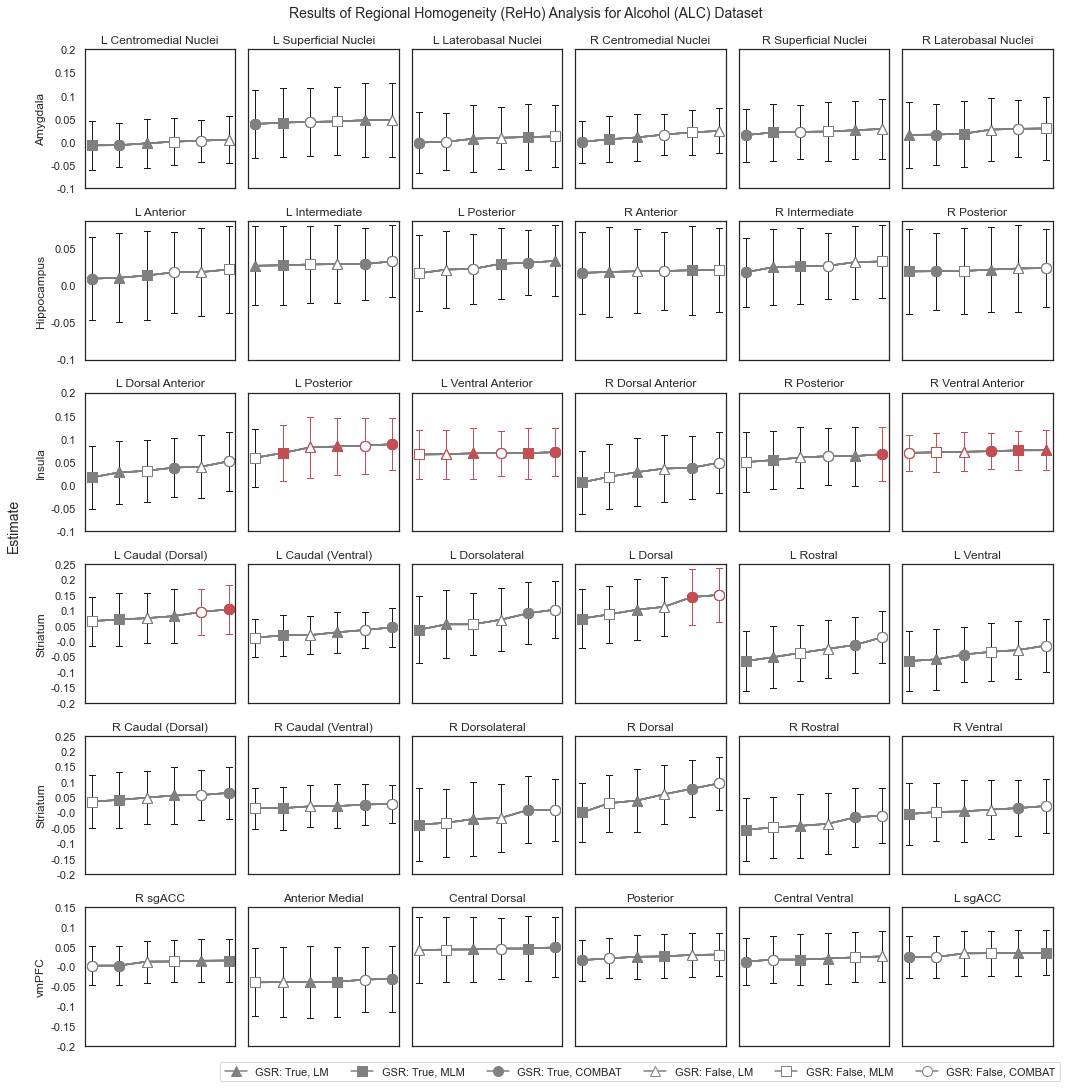

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


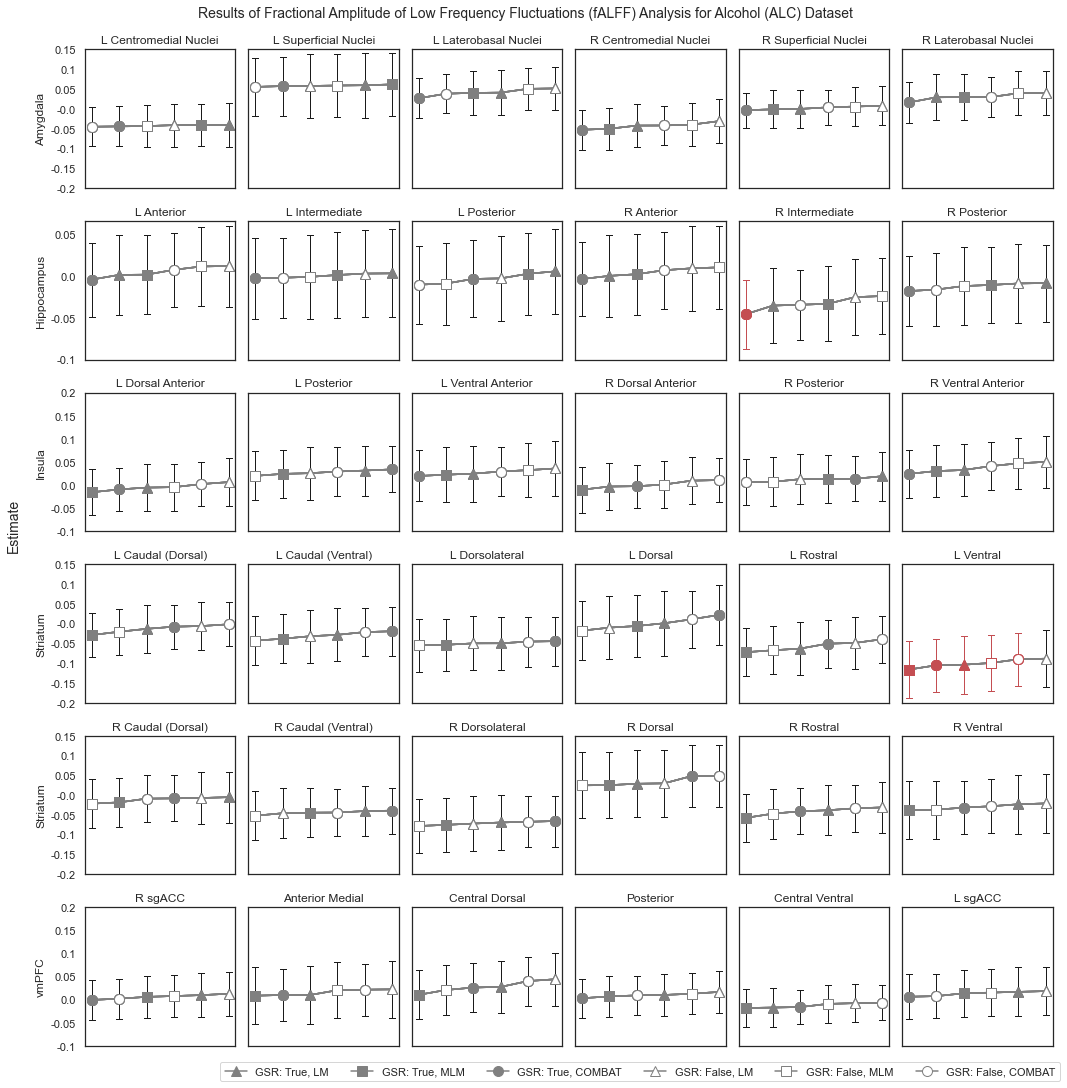

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


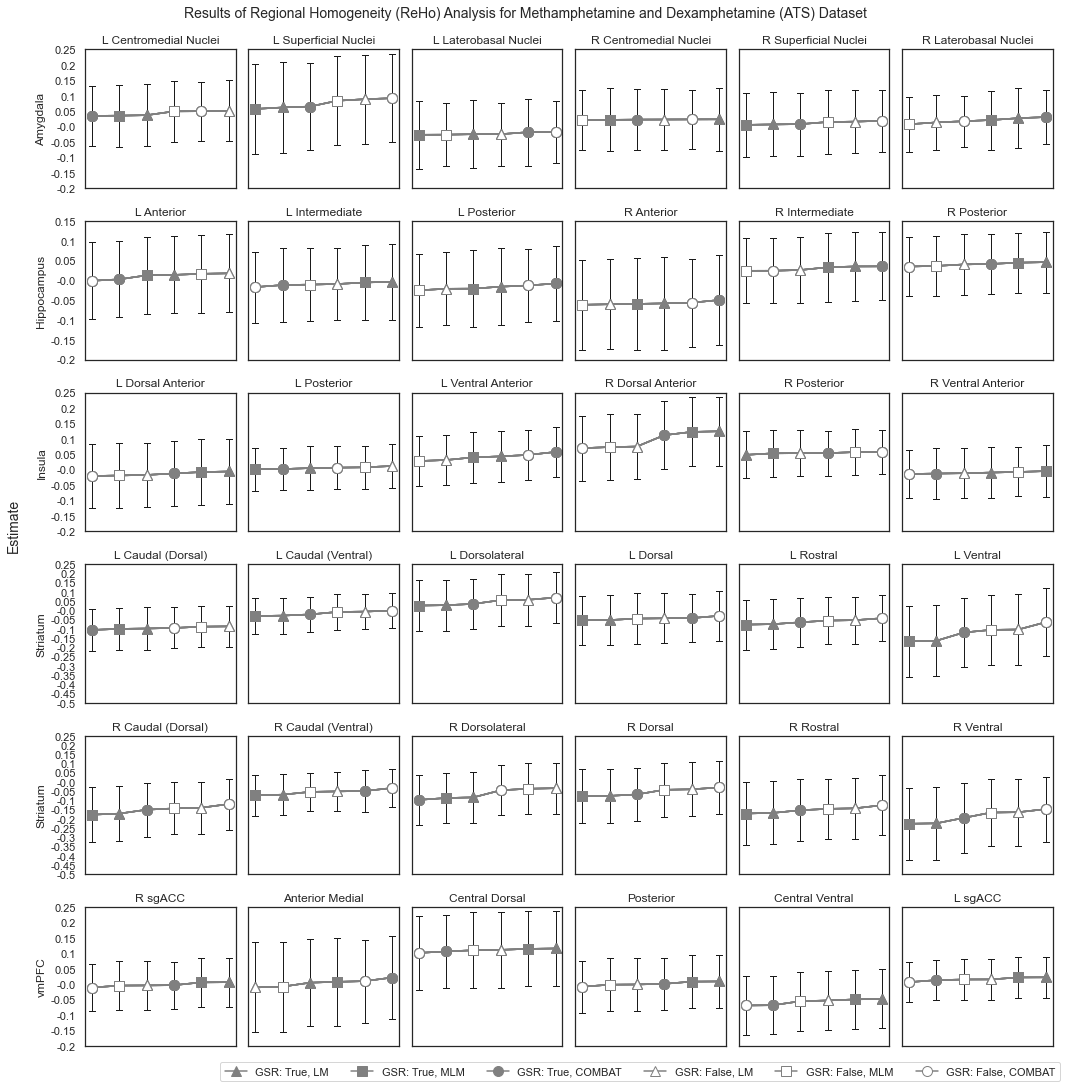

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


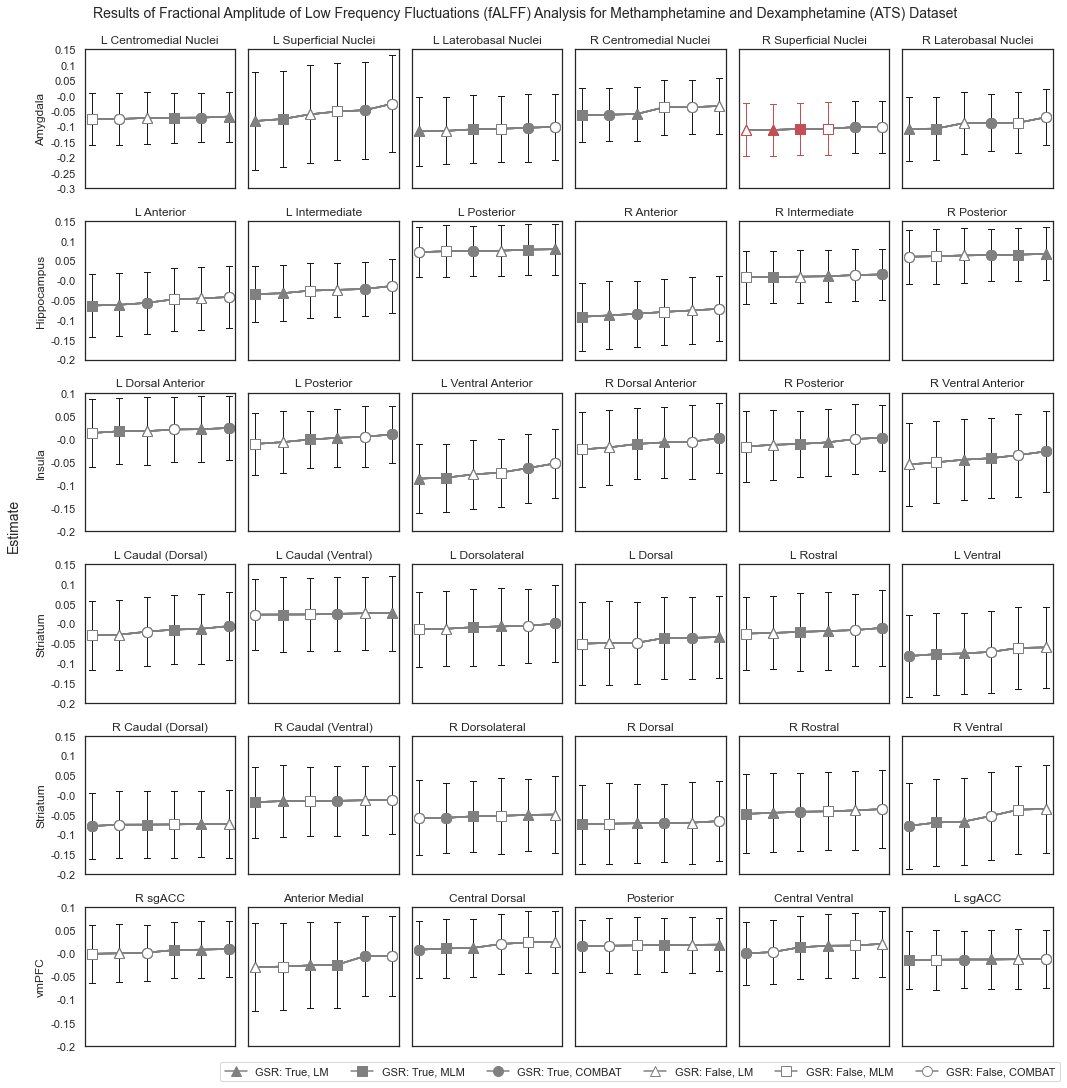

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


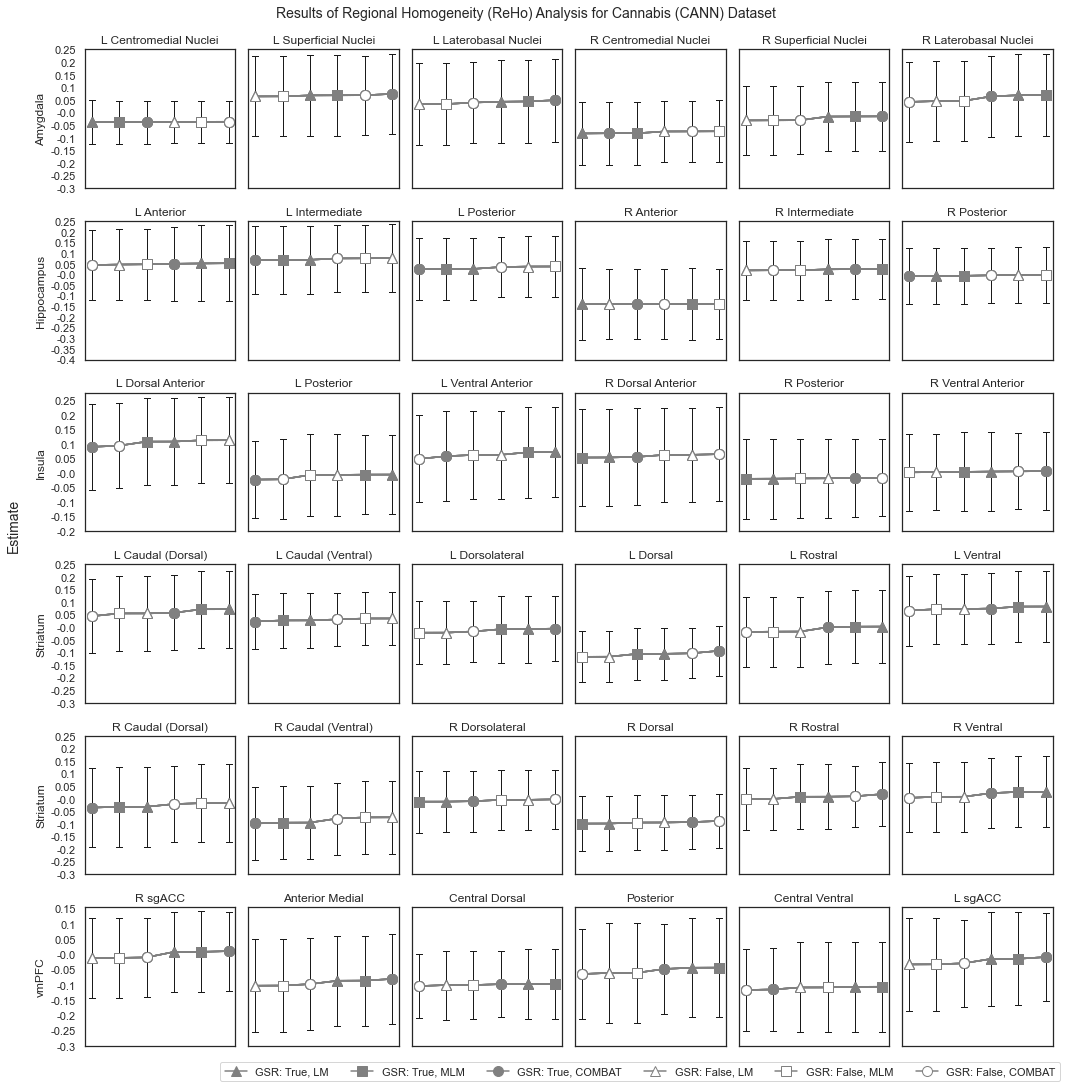

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


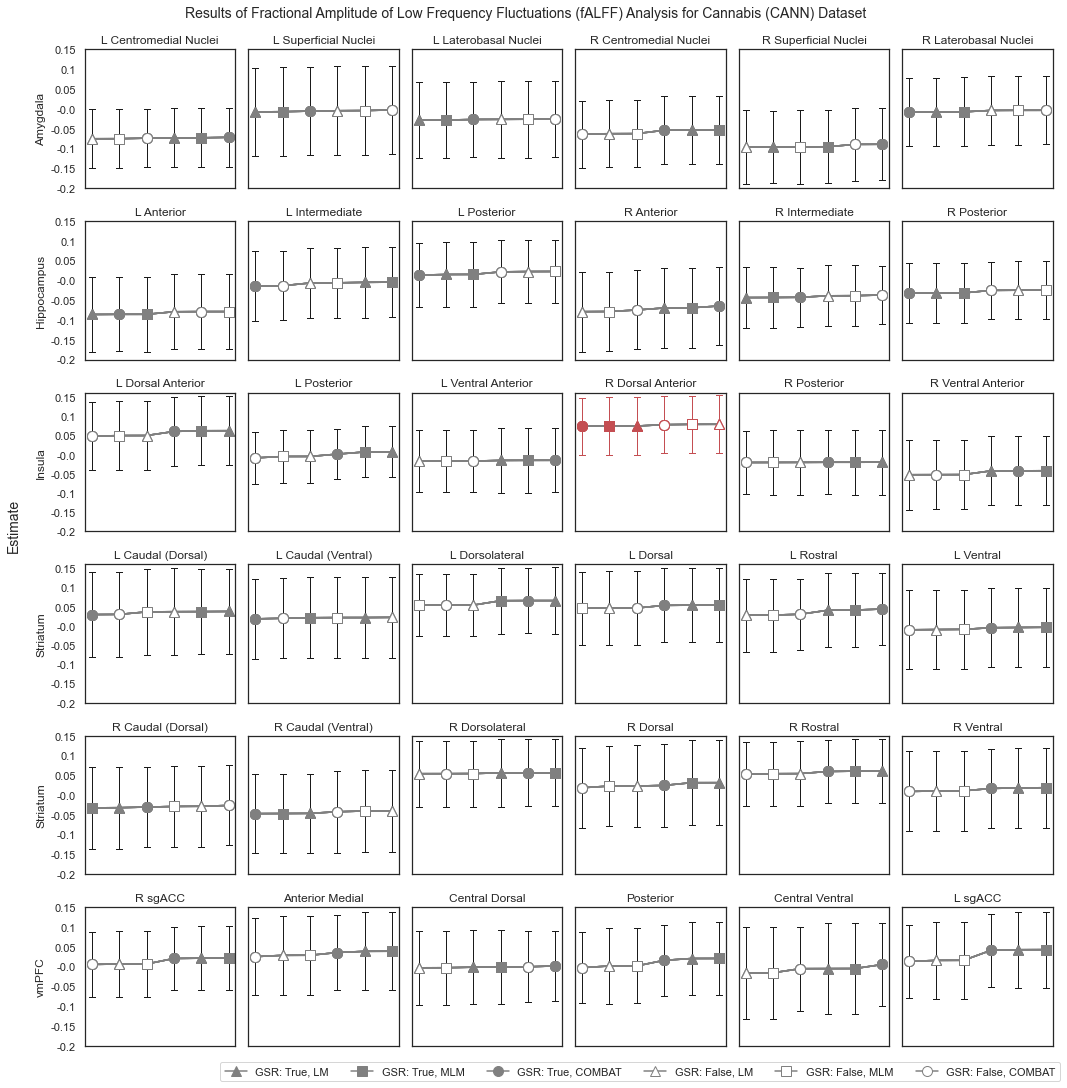

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


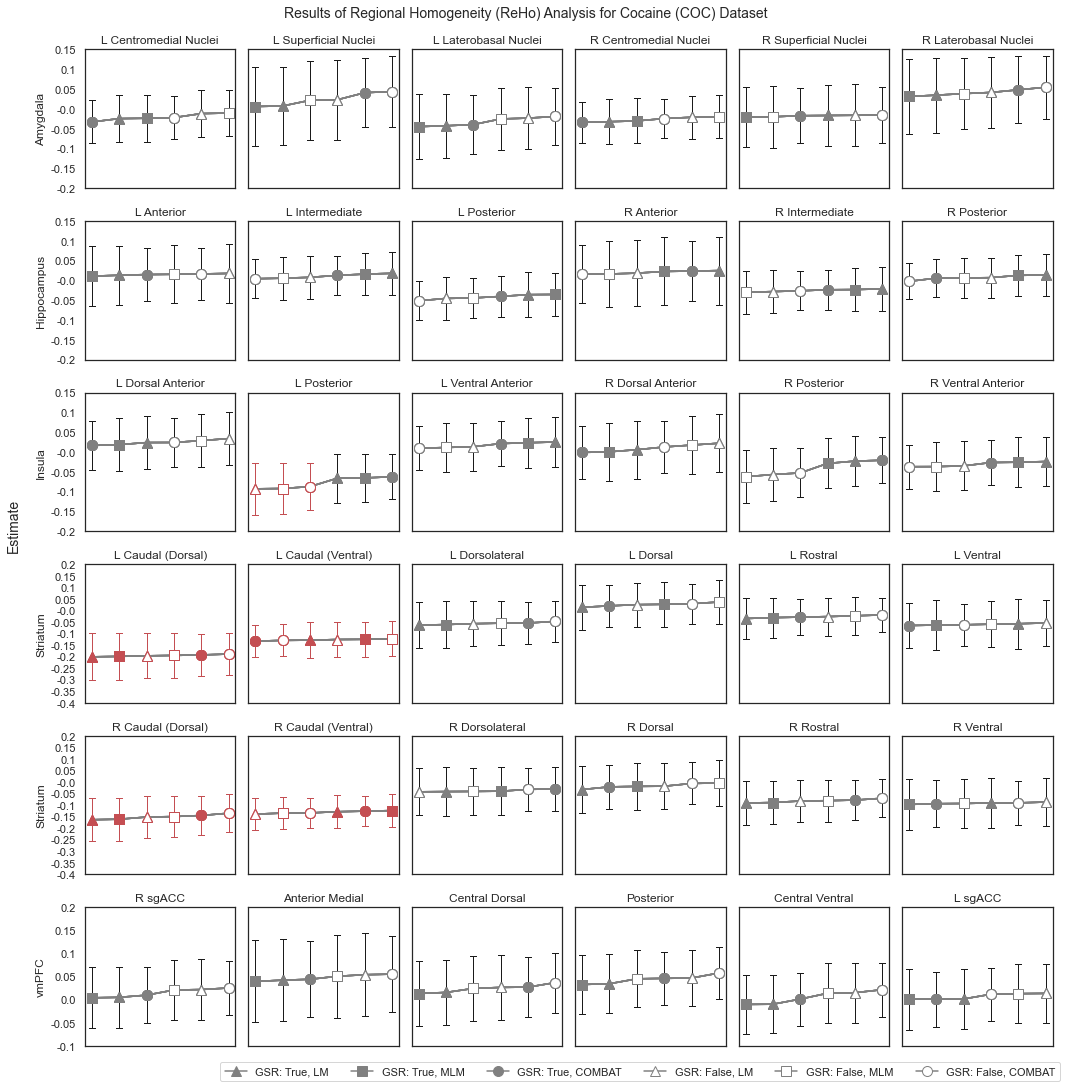

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


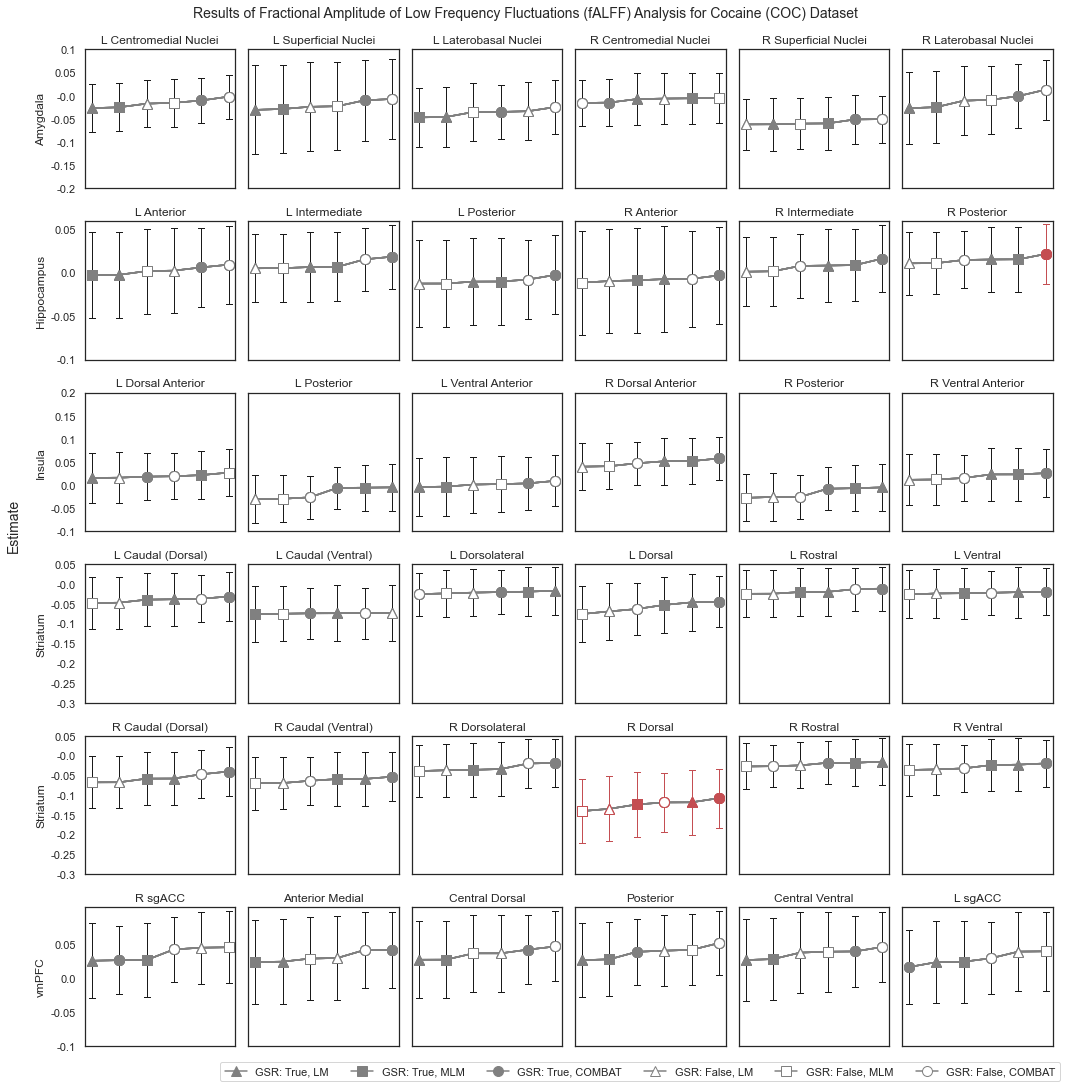

In [169]:
sns.set(style="white")
fontsize = 12
dsets = ["ALC", "ATS", "CANN", "COC"]
gsrs = ["-gsr", ""]
methods = ["-lm", "-mlm", "-combat"]
metrics = ["REHO", "FALFF"]
seeds = ["amygdala", "hippocampus", "insula", "striatum", "vmPFC"]

for dset, metric in itertools.product(dsets, metrics):
    fig, axes_arr = plt.subplots(6, 6)
    fig.set_size_inches(15, 15)
    for seed in seeds:
        yticks = np.arange(-1, 1.5, 0.5)
        temp_table = table.query(f'dset == "{dset}" & metric == "{metric}" & ROI == "{see2seed_dict[seed]}"')
        max_val = np.max(temp_table["95 CI H"].values)
        min_val = np.min(temp_table["95 CI L"].values)

        min_val = math.ceil(min_val * 10) / 10 if min_val > 0 else math.floor(min_val * 10) / 10
        max_val = math.ceil(max_val * 10) / 10 if max_val > 0 else math.floor(max_val * 10) / 10
        yticks = np.round(np.arange(min_val, max_val, 0.05), 2)
        
        if seed == "vmPFC":
            hemispheres = [""]
        else:
            hemispheres = ["lh", "rh"]
        for hemis in hemispheres:
            if seed == "amygdala":
                rois = [f"amygdala1{hemis}", f"amygdala2{hemis}", f"amygdala3{hemis}"]
                if hemis == "lh":
                    axes_lst = axes_arr[0, :3]
                elif hemis == "rh":
                    axes_lst = axes_arr[0, 3:]
            elif seed == "hippocampus":
                rois = [
                    f"hippocampus3solF1{hemis}",
                    f"hippocampus3solF2{hemis}",
                    f"hippocampus3solF3{hemis}",
                ]
                if hemis == "lh":
                    axes_lst = axes_arr[1, :3]
                elif hemis == "rh":
                    axes_lst = axes_arr[1, 3:]
            elif seed == "insula":
                rois = [f"insulaD{hemis}", f"insulaP{hemis}", f"insulaV{hemis}"]
                if hemis == "lh":
                    axes_lst = axes_arr[2, :3]
                elif hemis == "rh":
                    axes_lst = axes_arr[2, 3:]
            elif seed == "striatum":
                rois = [
                    f"striatumMatchCD{hemis}",
                    f"striatumMatchCV{hemis}",
                    f"striatumMatchDL{hemis}",
                    f"striatumMatchD{hemis}",
                    f"striatumMatchR{hemis}",
                    f"striatumMatchV{hemis}",
                ]
                if hemis == "lh":
                    axes_lst = axes_arr[3, :]
                elif hemis == "rh":
                    axes_lst = axes_arr[4, :]
            elif seed == "vmPFC":
                rois = ["vmPFC1", "vmPFC2", "vmPFC3", "vmPFC4", "vmPFC5", "vmPFC6"]
                axes_lst = axes_arr[5, :]
    
            for roi_i, roi in enumerate(rois):
                ax = axes_lst[roi_i]
                for gsr, method in itertools.product(gsrs, methods):
                    red_table = table.query(f'dset == "{dset}" & metric == "{metric}" & ROI == "{roi_dict[roi]}" & Seed == "{seed_dict[roi]}"')
                    specurve_plot(red_table, ax)
                    
                    ax.set_yticks(yticks)
                    if (roi == "amygdala1lh" or roi == "hippocampus3solF1lh" or roi == "insulaDlh" or roi == "striatumMatchCDlh" or roi == "striatumMatchCDrh" or roi == "vmPFC1"):
                        ax.set_ylabel(roi_dict[roi], fontsize=fontsize)
                        ax.set_yticklabels(yticks)
                    else:
                        ax.set_ylabel("")
                        ax.set_yticklabels([])
                    ax.set_title(seed_dict[roi], fontsize=fontsize)
                    
                    ax.set_xlabel("")
                    ax.set_xticklabels([])
                    if seed != "vmPFC":
                        ax.set_xticklabels([])
    
    # Organize handles and labels to plot legend
    handles, labels = ax.get_legend_handles_labels()
    true_labels = red_table["method"].to_list()
    true_labels_dict = {label: lab_i for lab_i, label in enumerate(true_labels)}
    
    n_labels = len(true_labels)
    short_handles, short_labels = (handles[:n_labels], labels[:n_labels])
    label_idx = [int(true_labels_dict[short_label]) for short_label in short_labels]

    short_handles = [val for (_, val) in sorted(zip(label_idx, short_handles), key=lambda x: x[0])]
    short_labels = true_labels

    fig.supylabel("Estimate", fontsize=fontsize+2)
    fig.suptitle(f"Results of {metric_dict[metric]} Analysis for {dset_dict[dset]}", fontsize=fontsize+2)
    fig.tight_layout(rect=[0.01, 0, 1, 0.99])
    fig.legend(short_handles, short_labels, loc='lower right', bbox_to_anchor=(1,-0.02), ncol=len(short_labels))
    # plt.subplots_adjust(top=0.95)
    plt.savefig(f"spec-curve_{dset}-{metric}.eps", bbox_inches="tight")
    plt.show()